In [1]:
import os
from nd2reader import ND2Reader
import napari
import numpy as np
from cellpose import models
from skimage.measure import regionprops_table
from skimage.io import imsave, imread
from skimage.segmentation import clear_border
from skimage.transform import resize
from skimage.morphology import remove_small_objects
import pandas as pd
from skimage.feature import blob_dog, blob_log
from utils import sharpest_frame_laplacian
from scipy.spatial.distance import cdist
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
model = models.Cellpose(gpu=True, model_type='cyto2')

dist_list = [2,4,6]
foci1_threshold = 0.01
foci2_threshold = 0.005

In [3]:
data_dir = r'I:\CBI\Kasia\data_analysis\2025_Fouquerel\data\53BP1 IF cenpB FISH -Lily'
masks_dir = r'I:\CBI\Kasia\data_analysis\2025_Fouquerel\analysis\250320_nuclei_masks'

os.makedirs(masks_dir, exist_ok=True)

In [4]:
file_list = [x for x in os.listdir(data_dir) if x.endswith('.nd2')]
file_list.sort()

In [ ]:
# use to run the analysis only on a selected file
#file_list = ['Batch Deconvolution_000_clone14_untransfected_unt_004.nd2']

In [5]:
for file_name in file_list:

    df_cell = pd.read_csv(os.path.join(masks_dir, file_name.replace('.nd2', '_cell_data.csv')))
    df_foci1 = pd.read_csv(os.path.join(masks_dir, file_name.replace('.nd2', '_foci1_data.csv')))
    df_foci2 = pd.read_csv(os.path.join(masks_dir, file_name.replace('.nd2', '_foci2_data.csv')))

    mask = imread(os.path.join(masks_dir, file_name.replace('.nd2', '_mask.png')))

    # Exclude background (cell 0)
    df_foci2 = df_foci2[df_foci2['cell'] != 0]

    foci_counts = df_foci2['cell'].value_counts().to_dict()

    fake_foci2 = []
    for cell_id, count in foci_counts.items():
        # Find all pixels belonging to the current cell
        cell_mask = (mask == cell_id).astype(np.uint8)
        cell_pixels = np.column_stack(np.where(cell_mask > 0))

        # Randomly sample new positions
        fake_positions = cell_pixels[np.random.choice(len(cell_pixels), count, replace=False)]

        for pos in fake_positions:
            fake_foci2.append([pos[1], pos[0], random.uniform(2.0, 5.0), cell_id])  # Random r value

    # Convert to DataFrame
    df_fake_foci2 = pd.DataFrame(fake_foci2, columns=['x', 'y', 'r', 'cell'])
    df_fake_foci2.to_csv(os.path.join(masks_dir, file_name[:-4] + '_foci2_ctrl_data.csv'), index=False)

    break
    # quantify foci pairs
    for cell in df_cell['cell']:
        
        # Select points for this cell
        foci1_cell = df_foci1.loc[df_foci1['cell'] == cell,['y', 'x']].values
        foci2_cell = df_fake_foci2.loc[df_fake_foci2['cell'] == cell,['y', 'x']].values
        
        if len(foci1_cell) == 0 or len(foci2_cell) == 0:
            continue

        # Compute pairwise distances
        distances = cdist(foci1_cell, foci2_cell, metric='euclidean')
        
        for d in dist_list:
            count = np.sum(distances < d)
            df_cell.loc[df_cell['cell'] == cell, f'foci1_foci2_{d}'] = count

        # save the data
        df_cell.to_csv(os.path.join(masks_dir, file_name[:-4] + '_cell_ctrl_data.csv'), index=False)

In [10]:
np.where(cell_mask > 0)

(array([1859, 1859, 1859, ..., 2001, 2001, 2001]),
 array([829, 830, 831, ..., 875, 876, 877]))

In [11]:
cell_pixels

array([[1859,  829],
       [1859,  830],
       [1859,  831],
       ...,
       [2001,  875],
       [2001,  876],
       [2001,  877]])

## Visualize ctrl graphs

In [21]:
file_list = [x for x in os.listdir(masks_dir) if x.endswith('cell_ctrl_data.csv')]

In [22]:
# load data
df = pd.concat([pd.read_csv(os.path.join(masks_dir, x)) for x in file_list], ignore_index=True)

Text(0, 0.5, 'Number of pairs')

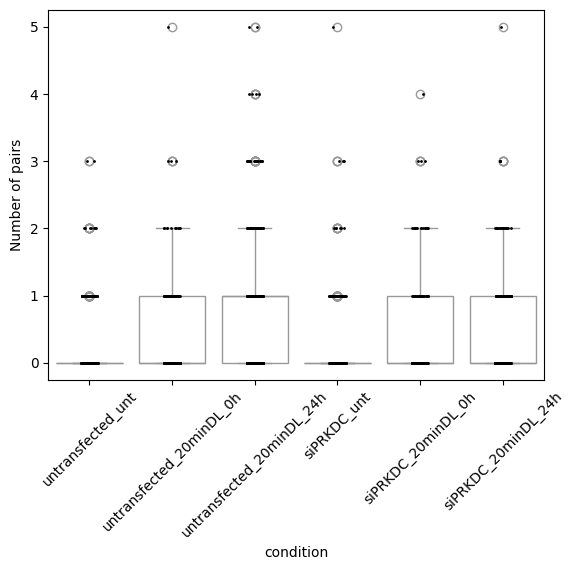

In [23]:
order = ['untransfected_unt', 'untransfected_20minDL_0h', 'untransfected_20minDL_24h', 'siPRKDC_unt', 'siPRKDC_20minDL_0h', 'siPRKDC_20minDL_24h']

sns.boxplot(df,x='condition',y='foci1_foci2_4',color='white', order = order)
sns.stripplot(df,x='condition',y='foci1_foci2_4',color='black',size=2, order = order)
plt.xticks(rotation=45)
plt.ylabel('Number of pairs')

Text(0, 0.5, 'mCherry foci count')

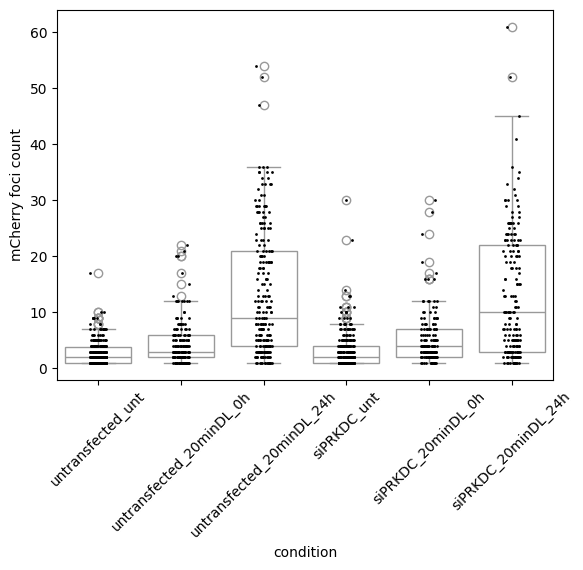

In [24]:
sns.boxplot(df,x='condition',y='foci2_count',color='white', order = order)  
sns.stripplot(df,x='condition',y='foci2_count',color='black',size=2, order= order)
plt.xticks(rotation=45)
plt.ylabel('mCherry foci count')